# Deep Sea Coral Data Analaysis

This notebook contains an analysis on the [NOAA Deep Sea Coral Dataset](https://deepseacoraldata.noaa.gov/). I found this dataset and wanted to learn what I could from it.


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# from matplotlib import animation, rc
# from IPython.display import HTML

## Data Preprocessing

In [20]:
coral_data = pd.read_csv('deep_sea_corals_data.csv')

/Users/kyle/.conda/envs/notebooks/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3,10,11,12,15,16,20,21,22,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Getting rid of the 0th row in the table as it only has additional metadata on the columns

In [21]:
coral_data = coral_data.drop(axis=0, index=0)

#### Overview of coral data
There are 28 different columns in this dataset. What kind of information can we learn about it?

In [3]:
coral_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762132 entries, 1 to 762132
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ShallowFlag              762132 non-null  float64
 1   DatasetID                762132 non-null  object 
 2   CatalogNumber            762132 non-null  float64
 3   SampleID                 618498 non-null  object 
 4   Repository               755149 non-null  object 
 5   ScientificName           762132 non-null  object 
 6   VernacularNameCategory   762132 non-null  object 
 7   TaxonRank                762132 non-null  object 
 8   IdentificationQualifier  745630 non-null  object 
 9   Locality                 640014 non-null  object 
 10  latitude                 762132 non-null  object 
 11  longitude                762132 non-null  object 
 12  DepthInMeters            762132 non-null  object 
 13  DepthMethod              761850 non-null  object 
 14  Obse

The `ObservationDate` column of the dataset contains strings, in the format `'YYYY', 'YYYY-MM',` or `'YYYY-MM-DD'`.
This function normalizes this data.

In [22]:
from datetime import datetime
import math
def clean_date(date):
    """ Used to clean the observation date of the coral """
    if isinstance(date, float) and math.isnan(date): return date  # skip nan values
    if date == '-999': return float('nan')

    split_date = date.split('-')
    if len(split_date) == 1:
        year = int(split_date[0])
        month = 1
        day = 1
    elif len(split_date) == 2:
        year = int(split_date[0])
        month = int(split_date[1])
        day = 1
    else:
        year = int(split_date[0])
        month = int(split_date[1])
        day = int(split_date[2])

    return datetime(year=year, month=month, day=day)

coral_data['ObservationDate'] = coral_data['ObservationDate'].map(lambda x: clean_date((x)))

### Observations over the years

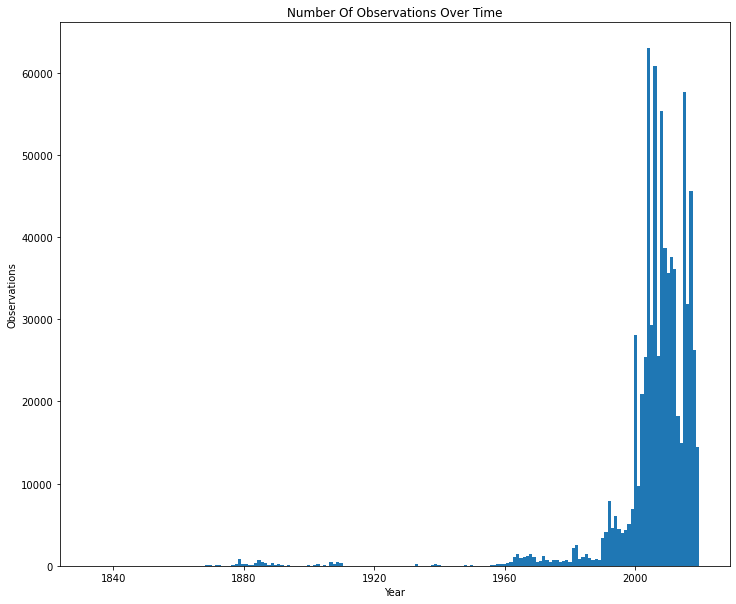

In [30]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('Number Of Observations Over Time')
ax.set_ylabel('Observations')
ax.set_xlabel('Year')
n_years = coral_data['ObservationDate'].max().year - coral_data['ObservationDate'].min().year
_ = ax.hist(
    coral_data['ObservationDate'],
    bins=n_years
)

In [ ]:
def clean_geopoints(point):
    """ Clean lat/lon points """
    try:
        return float(point)
    except Exception:
        return float('nan')
coral_data['longitude'] = coral_data['longitude'].map(lambda x: clean_geopoints(x))
coral_data['latitude'] = coral_data['latitude'].map(lambda x: clean_geopoints(x))

In [34]:
def to_float(val):
    """ Convert values to float if possible """
    val = float(val)
    if val == -999.0:
        return float('nan')
    return val
coral_data['Temperature'] = coral_data['Temperature'].map(lambda x: to_float(x))
coral_data['Oxygen'] = coral_data['Oxygen'].map(lambda x: to_float(x))

## Where are the datapoints?
We have data from all over the world. Lets see exactly where they are...

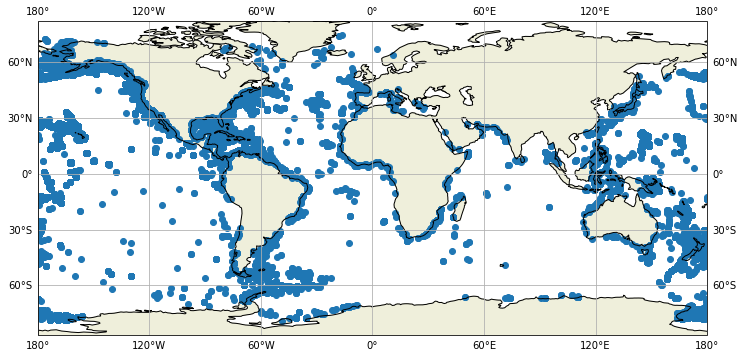

In [39]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True)
ax.scatter(
    x=coral_data['longitude'],
    y=coral_data['latitude']
)

### Temperature Changes over Time
Let's take a look at how temperature readings have changed over time. A normal scatter plot
will do nicely.

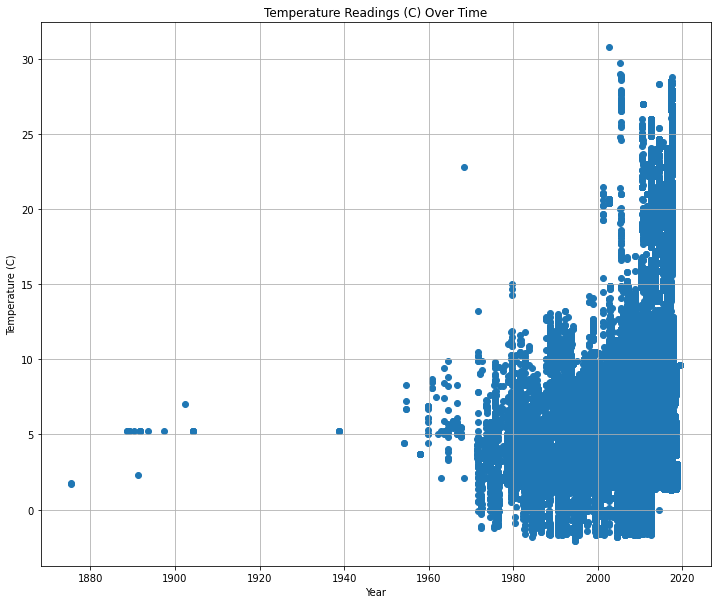

In [41]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('Temperature Readings (C) Over Time')
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Year')
ax.grid(linestyle='-')
ax.scatter(
    x=coral_data['ObservationDate'],
    y=coral_data['Temperature'],
)

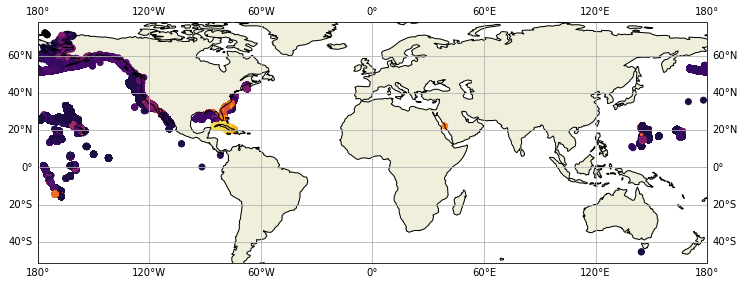

In [37]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True)
ax.scatter(
    x=coral_data['longitude'],
    y=coral_data['latitude'],
    c=coral_data['Temperature'], cmap='inferno'
)

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.grid(linestyle='-')
ax.scatter(
    x=coral_data['ObservationDate'],
    y=coral_data['Oxygen'],
)

In [124]:
coral_data['pCO2'].unique()

array(['-999.0', -999.0], dtype=object)

In [126]:
coral_data['pH'].unique()

array([-999.])